In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline  

In [2]:
np.random.seed(1)

# Generate simulated samples

In [3]:
def generate_landmarks(ball_radius=20, num_lmks = 50,num_layers=100):
    layer_height = ball_radius / num_layers
    angular_dist = 2 * np.pi / num_lmks
    height = 0
    landmark = pd.DataFrame({})
    for i in range(num_layers):
        height = height + layer_height 
        z = height
        r = np.sqrt(ball_radius**2 - (i * layer_height)**2)
        for j in range(num_lmks):
            x = r * np.cos(angular_dist * j)
            y = r * np.sin(angular_dist * j)
            this_loop = pd.DataFrame({"X":[x], "Y":[y], "Z":[z]})
            landmark = landmark.append(this_loop)
    landmark = generate_scans(landmark, sd=0.1/np.sqrt(3))
    return landmark

def generate_scans(landmark, sd=0.01/np.sqrt(3)):
    noise = np.random.normal(0, sd, size=landmark.shape)
    return (landmark + noise)

# True Design
num_layers=100
ball_radius = 20
num_lmks = 50
layer_height = ball_radius / num_layers
angular_dist = 2 * np.pi / num_lmks
height = 0
true_design = pd.DataFrame({})
for i in range(num_layers):
    height = height + layer_height
    z = height
    r = np.sqrt(ball_radius**2 - (i * layer_height)**2)
    for j in range(num_lmks):
        x = r * np.cos(angular_dist * j)
        y = r * np.sin(angular_dist * j)
        this_loop = pd.DataFrame({"X":[x], "Y":[y], "Z":[z]})
        true_design = true_design.append(this_loop)

# Process Planning

In [4]:
def calculate_mean(configs):
    sums = 0
    for i in range(len(configs)):
        sums += configs[i]
    return sums / (len(configs))

In [5]:
# Unique object
def ss_unique(configs, mean):
    Sx = 0
    Sy = 0
    Sz = 0
    num_scans = len(configs)
    for i in range(num_scans):
        Sx += (configs[i]['X'].values - mean['X'].values)**2
        Sy += (configs[i]['Y'].values - mean['Y'].values)**2
        Sz += (configs[i]['Z'].values - mean['Z'].values)**2
        
    return {'Sx': Sx, 'Sy': Sy, 'Sz': Sz, 'num_scans': num_scans}

In [6]:
def process_planning_unique(ss, δ = 0.01, ts = 0.01, tp = 0, q=2.1):
    q = q**2
    ts_sq = tp**2 + ts**2
    s = ss['num_scans']
    Sx = ss['Sx']
    Sy = ss['Sy']
    Sz = ss['Sz']
    a = 3 - q * (Sx + Sy + Sz) / (s * δ**2)
    b = q * ts_sq / (δ**2)
    n = (- a + np.sqrt(a**2 + 4 * b)) / 2
    n = np.max(np.ceil(n))
    return n

In [7]:
# Difference criteria
def max_dev(sample_mean, true_design):
    x_diff = (sample_mean["X"] - true_design["X"])**2
    y_diff = (sample_mean["Y"] - true_design["Y"])**2
    z_diff = (sample_mean["Z"] - true_design["Z"])**2
    max_diff = np.max(np.sqrt(x_diff+y_diff+z_diff))
    return(max_diff)

# Simulation: multiple scans

1. Test the maximum deviation with different number of scans and the controlled error
2. Test the performance of different priors
3. Test $q$ value

In [8]:
# Objective 1

# Generate scans and process planning
# for each unique object
# the stopping crieteria is the loop number i > n

# Dataframe recording the result for each simulation
# Object: the code for each of the 20 objects
# s: current number of scans
# n: optimal required number of scans based on s
# MaxDev: the maximum deviation of between the mean model and the true design
# ts: prior value
result1 = pd.DataFrame({"Object": [], "s": [], "n": [], "MaxDev": [], "delta": []})
result2 = pd.DataFrame({"Object": [], "s": [], "n": [], "MaxDev": [], "delta": []})
result3 = pd.DataFrame({"Object": [], "s": [], "n": [], "MaxDev": [], "delta": []})

q = 2.2

for i in range(30):
    # initialization
    unique_part = true_design
    scans = []
    scans.append(generate_scans(unique_part))
    mean = scans[0]
    ss = ss_unique(scans, mean)
    num_scans = len(scans)

    
    n1 = (q * 0.01 / 0.01) ** 2
    diff1 = max_dev(mean, true_design)
    this_loop1 = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n1], "MaxDev": [diff1], "delta": [0.01]})
    result1 = result1.append(this_loop1)
    
    n2 = (q * 0.01 / 0.005) ** 2
    diff2 = max_dev(mean, true_design)
    this_loop2 = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n2], "MaxDev": [diff2], "delta": [0.005]})
    result2 = result2.append(this_loop2)
    
    n3 = (q * 0.01 / 0.003) ** 2
    diff3 = max_dev(mean, true_design)
    this_loop3 = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n3], "MaxDev": [diff3], "delta": [0.003]})
    result3 = result3.append(this_loop3)

    while ((num_scans < n1) or (num_scans < n2) or (num_scans < n3)):
        scans.append(generate_scans(unique_part))
        num_scans = len(scans)
        mean = calculate_mean(scans)
        ss = ss_unique(scans, mean)
        
        if (num_scans < n1):
            n1 = process_planning_unique(ss, δ=0.01,q=q)
            diff1 = max_dev(mean, true_design)
            this_loop1 = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n1], "MaxDev": [diff1], "delta": [0.01]})
            result1 = result1.append(this_loop1)
            
        if (num_scans < n2):
            n2 = process_planning_unique(ss, δ=0.005,q=q)
            diff2 = max_dev(mean, true_design)
            this_loop2 = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n2], "MaxDev": [diff2], "delta": [0.005]})
            result2 = result2.append(this_loop2)
            
        if (num_scans < n3):
            n3 = process_planning_unique(ss, δ=0.003,q=q)
            diff3 = max_dev(mean, true_design)
            this_loop3 = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n3], "MaxDev": [diff3], "delta": [0.003]})
            result3 = result3.append(this_loop3)




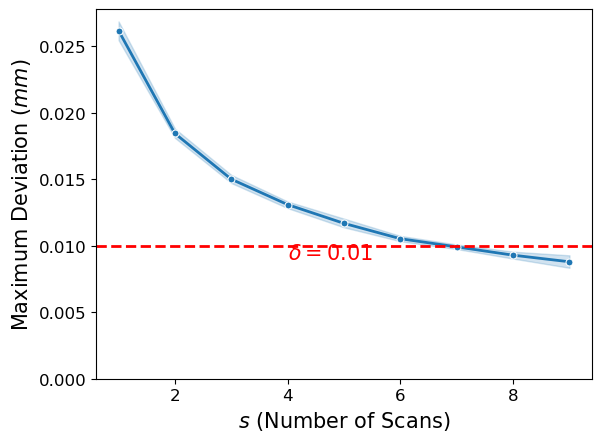

In [4]:
plt.style.use("default")
g = sns.lineplot(
    data=result1,
    x="s", y="MaxDev",
    marker='o', linewidth=2,markersize=5
)


g.axhline(0.01, ls="--", c='r', linewidth=2)

plt.xticks(np.arange(2, np.max(result1['s']) + .1, step=2), fontsize=12)
plt.yticks(np.arange(0, 0.0275, step=0.005), fontsize=12)
plt.xlabel("$s$ (Number of Scans)", fontsize=15)
plt.ylabel("Maximum Deviation ($mm$)", fontsize=15)

plt.text(4, 0.009, "$\delta = 0.01$", fontsize=15, c='r')
plt.savefig("delta=01.png", dpi=600)

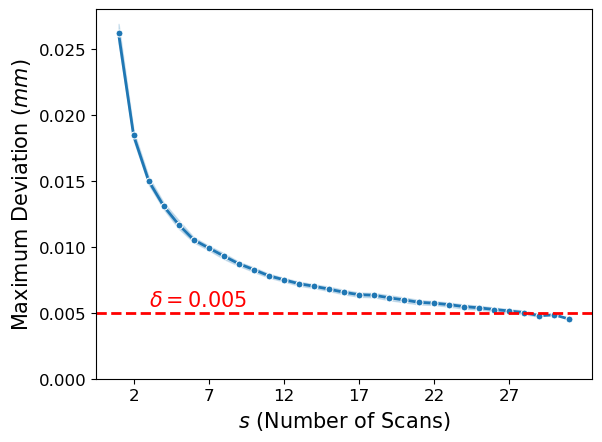

In [5]:
plt.style.use("default")
g = sns.lineplot(
    data=result2,
    x="s", y="MaxDev",
    marker='o', linewidth=2,markersize=5
)


g.axhline(0.005, ls="--", c='r', linewidth=2)

plt.xticks(np.arange(2, np.max(result2['s']) + .1, step=5), fontsize=12)
plt.yticks(np.arange(0, 0.0275, step=0.005), fontsize=12)
plt.xlabel("$s$ (Number of Scans)", fontsize=15)
plt.ylabel("Maximum Deviation ($mm$)", fontsize=15)

plt.text(3, 0.0055, "$\delta = 0.005$", fontsize=15, c='r')
plt.savefig("delta=005.png", dpi=600)

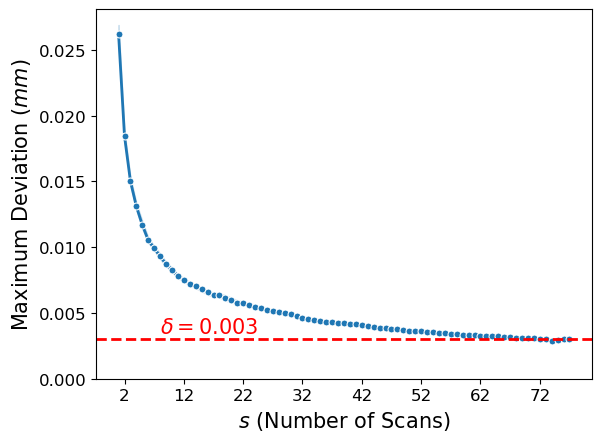

In [6]:
plt.style.use("default")
g = sns.lineplot(
    data=result3,
    x="s", y="MaxDev",
    marker='o', linewidth=2,markersize=5
)


g.axhline(0.003, ls="--", c='r', linewidth=2)

plt.xticks(np.arange(2, np.max(result3['s']) + .1, step=10), fontsize=12)
plt.yticks(np.arange(0, 0.0275, step=0.005), fontsize=12)
plt.xlabel("$s$ (Number of Scans)", fontsize=15)
plt.ylabel("Maximum Deviation ($mm$)", fontsize=15)

plt.text(8, 0.0035, "$\delta = 0.003$", fontsize=15, c='r')
plt.savefig("delta=003.png", dpi=600)

In [14]:
# Objective 2

# Generate scans and process planning
# for each unique object
# the stopping crieteria is the loop number i > n

# Dataframe recording the result for each simulation
# Object: the code for each of the 20 objects
# s: current number of scans
# n: optimal required number of scans based on s
# MaxDev: the maximum deviation of between the mean model and the true design
# ts: prior value
result = pd.DataFrame({"Object": [], "s": [], "n": [], "MaxDev": [], "ts": []})

q = 2.1

for i in range(30):
    # initialization
    unique_part = true_design
    scans = []
    scans.append(generate_scans(unique_part))
    mean = scans[0]
    ss = ss_unique(scans, mean)
    num_scans = len(scans)

    n = 100
    n1 = 100
    n2 = 100
    while ((num_scans < n) or (num_scans < n1) or (num_scans < n2)):
        scans.append(generate_scans(unique_part))
        num_scans = len(scans)
        mean = calculate_mean(scans)
        ss = ss_unique(scans, mean)
        diff = max_dev(mean, true_design)
        if (num_scans < n):
            n = process_planning_unique(ss, ts = 0.01, δ=0.01, q=q)
            this_loop = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n], "MaxDev": [diff], "ts": [0.01]})
            result = result.append(this_loop)
                
        if (num_scans < n1):
            n1 = process_planning_unique(ss, ts=0.02, δ=0.01, q=q)
            this_loop1 = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n1], "MaxDev": [diff], "ts": [0.02]})
            result = result.append(this_loop1)
            
        if (num_scans < n2):
            n2 = process_planning_unique(ss, ts=0.002, δ=0.01, q=q)
            this_loop2 = pd.DataFrame({"Object": [i], "s": [num_scans], "n": [n2], "MaxDev": [diff], "ts": [0.002]})
            result = result.append(this_loop2)

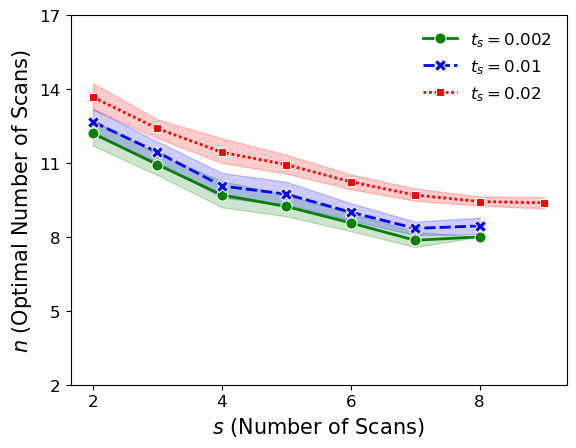

In [5]:
colors = ['green', 'blue', 'red']
# colors = ['green', 'blue']

plt.style.use("default")
sns.set_palette("husl")
g = sns.lineplot(
    data=result,
    x="s", y="n", hue="ts", style="ts",
    markers=True, linewidth=2, markersize=8, palette=colors
)


plt.xticks(np.arange(2, np.max(result['s'])+.1, step=2), fontsize=12)
plt.yticks(np.arange(2, np.max(result['n'])+.1, step=3), fontsize=12)
plt.xlabel("$s$ (Number of Scans)", fontsize=15)
plt.ylabel("$n$ (Optimal Number of Scans)", fontsize=15)
plt.legend(fontsize=12, frameon=False, labels=['$t_s = 0.002$', '$t_s=0.01$', '$t_s=0.02$'])
plt.savefig("multiple_ts.png", dpi=600)

# Simulation: Multiple Parts

In [17]:
result1 = pd.DataFrame({"rep": [], "s": [], "p":[], "m": [], "MaxDev": [], "epsilon": []})
result2 = pd.DataFrame({"rep": [], "s": [], "p":[], "m": [], "MaxDev": [], "epsilon": []})
result3 = pd.DataFrame({"rep": [], "s": [], "p":[], "m": [], "MaxDev": [], "epsilon": []})

q = 2.2

for i in range(30):

    # initialization
    s = 10
    p = 2

    means = []

    part1 = generate_landmarks()
    part2 = generate_landmarks()

    scans1 = []
    for j in range(s):
        scans1.append(generate_scans(part1))
    mean1 = calculate_mean(scans1)
    means.append(mean1)

    scans2 = []
    for j in range(s):
        scans2.append(generate_scans(part2))
    mean2 = calculate_mean(scans2)
    means.append(mean2)

    tot_mean = calculate_mean(means)
    ss = ss_unique(means, tot_mean)

    m1 = process_planning_unique(ss, δ = 0.1, ts=0.01, tp=0.1, q=q)   
    diff1 = max_dev(tot_mean, true_design)
    this_loop1 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m1], "MaxDev": [diff1], "epsilon": [0.1]})
    result1 = result1.append(this_loop1)

    m2 = process_planning_unique(ss, δ = 0.05, ts=0.01, tp=0.1, q=q)   
    diff2 = max_dev(tot_mean, true_design)
    this_loop2 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m2], "MaxDev": [diff2], "epsilon": [0.05]})
    result2 = result2.append(this_loop2)

    m3 = process_planning_unique(ss, δ = 0.03, ts=0.01, tp=0.1, q=q)   
    diff3 = max_dev(tot_mean, true_design)
    this_loop3 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m3], "MaxDev": [diff3], "epsilon": [0.03]})
    result3 = result3.append(this_loop3)

    while ((p < m1) or (p < m2) or (p < m3)):
        part_temp = generate_landmarks()
        p += 1
        scans = []
        for i in range(s):
            scans.append(generate_scans(part_temp))
        mean_p = calculate_mean(scans)
        means.append(mean_p)

        tot_mean = calculate_mean(means)

        ss = ss_unique(means, tot_mean)
        
        if (p < m1):
            m1 = process_planning_unique(ss, δ = 0.1, ts=0.01, tp=0.1, q=q)   
            diff1 = max_dev(tot_mean, true_design)
            this_loop1 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m1], "MaxDev": [diff1], "epsilon": [0.1]})
            result1 = result1.append(this_loop1)
        
        if (p < m2):
            m2 = process_planning_unique(ss, δ = 0.05, ts=0.01, tp=0.1, q=q)
            diff2 = max_dev(tot_mean, true_design)
            this_loop2 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m2], "MaxDev": [diff2], "epsilon": [0.05]})
            result2 = result2.append(this_loop2)
        
        if (p < m3):
            m3 = process_planning_unique(ss, δ = 0.03, ts=0.01, tp=0.1, q=q)
            diff3 = max_dev(tot_mean, true_design)
            this_loop3 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m3], "MaxDev": [diff3], "epsilon": [0.03]})
            result3 = result3.append(this_loop3)
  

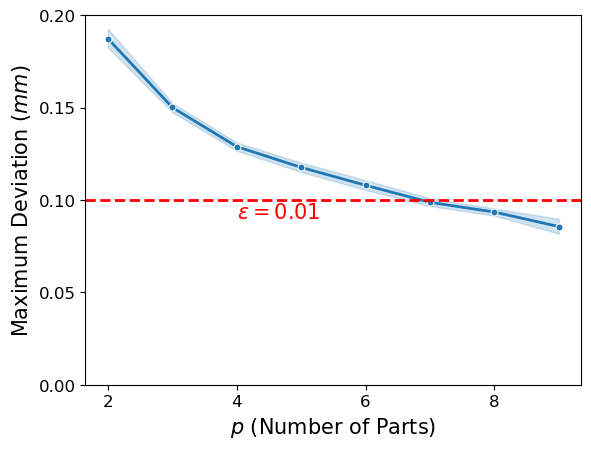

In [10]:
plt.style.use("default")
g = sns.lineplot(
    data=result1,
    x="p", y="MaxDev",
    marker='o', linewidth=2,markersize=5
)


g.axhline(0.1, ls="--", c='r', linewidth=2)

plt.xticks(np.arange(2, np.max(result1['p']) + .1, step=2), fontsize=12)
plt.yticks(np.arange(0, 0.21, step=0.05), fontsize=12)
plt.xlabel("$p$ (Number of Parts)", fontsize=15)
plt.ylabel("Maximum Deviation ($mm$)", fontsize=15)

plt.text(4, 0.09, "$\epsilon = 0.01$", fontsize=15, c='r')
plt.savefig("epsilon=1.png", dpi=600)

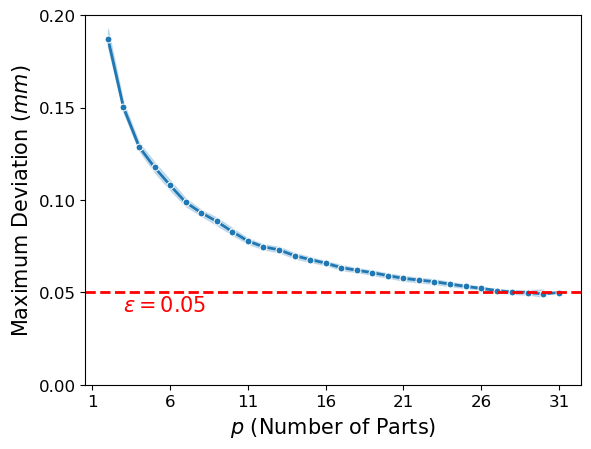

In [11]:
plt.style.use("default")
g = sns.lineplot(
    data=result2,
    x="p", y="MaxDev",
    marker='o', linewidth=2,markersize=5
)


g.axhline(0.05, ls="--", c='r', linewidth=2)

plt.xticks(np.arange(1, np.max(result2['p']) +.1, step=5), fontsize=12)
plt.yticks(np.arange(0, 0.21, step=0.05), fontsize=12)
plt.xlabel("$p$ (Number of Parts)", fontsize=15)
plt.ylabel("Maximum Deviation ($mm$)", fontsize=15)

plt.text(3, 0.04, "$\epsilon = 0.05$", fontsize=15, c='r')
plt.savefig("epsilon=05.png", dpi=600)

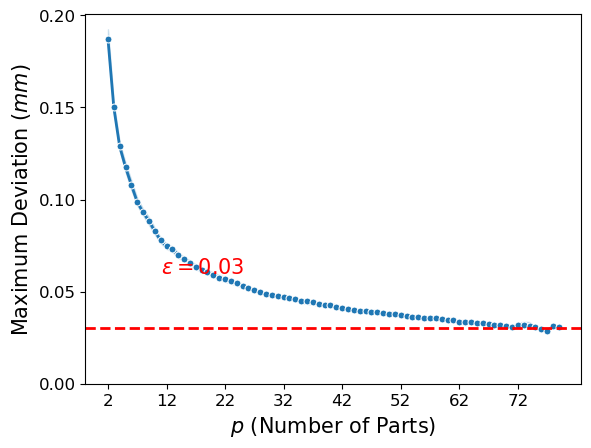

In [12]:
plt.style.use("default")
g = sns.lineplot(
    data=result3,
    x="p", y="MaxDev",
    marker='o', linewidth=2,markersize=5
)


g.axhline(0.03, ls="--", c='r', linewidth=2)

plt.xticks(np.arange(2, np.max(result3['p']) + .1, step=10), fontsize=12)
plt.yticks(np.arange(0, 0.21, step=0.05), fontsize=12)
plt.xlabel("$p$ (Number of Parts)", fontsize=15)
plt.ylabel("Maximum Deviation ($mm$)", fontsize=15)

plt.text(11, 0.06, "$\epsilon = 0.03$", fontsize=15, c='r')
plt.savefig("epsilon=03.png", dpi=600)

In [23]:
result = pd.DataFrame({"rep": [], "s": [], "p":[], "m": [], "MaxDev": [], "tp": []})

for i in range(30):

    # initialization
    s = 10
    p = 2

    means = []

    part1 = generate_scans(true_design, sd=0.1/3)
    part2 = generate_scans(true_design, sd=0.1/3)

    scans1 = []
    for j in range(s):
        scans1.append(generate_scans(part1))
    mean1 = calculate_mean(scans1)
    means.append(mean1)

    scans2 = []
    for j in range(s):
        scans2.append(generate_scans(part2))
    mean2 = calculate_mean(scans2)
    means.append(mean2)

    tot_mean = calculate_mean(means)
    ss = ss_unique(means, tot_mean)

    m1 = process_planning_unique(ss, δ = 0.05, ts=0.01, tp=0.1)   
    diff1 = max_dev(tot_mean, true_design)
    this_loop1 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m1], "MaxDev": [diff1], "tp": [0.1]})

    m2 = process_planning_unique(ss, δ = 0.05, ts=0.01, tp=0.2)   
    diff2 = max_dev(tot_mean, true_design)
    this_loop2 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m2], "MaxDev": [diff2], "tp": [0.2]})

    m3 = process_planning_unique(ss, δ = 0.05, ts=0.01, tp=0.02)   
    diff3 = max_dev(tot_mean, true_design)
    this_loop3 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m3], "MaxDev": [diff3], "tp": [0.02]})

    result = result.append(this_loop1)
    result = result.append(this_loop2)
    result = result.append(this_loop3)

    while ((p < m1) or (p < m2) or (p < m3)):
        part_temp = generate_scans(true_design, sd=0.1/3)
        p += 1
        scans = []
        for i in range(s):
            scans.append(generate_scans(part_temp))
        mean_p = calculate_mean(scans)
        means.append(mean_p)

        tot_mean = calculate_mean(means)

        ss = ss_unique(means, tot_mean)

        if (p < m1):
            m1 = process_planning_unique(ss, δ = 0.05, ts=0.01, tp=0.1)   
            diff1 = max_dev(tot_mean, true_design)
            this_loop1 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m1], "MaxDev": [diff1], "tp": [0.1]})
            result = result.append(this_loop1)

        if (p < m2):
            m2 = process_planning_unique(ss, δ = 0.05, ts=0.01, tp=0.2)   
            diff2 = max_dev(tot_mean, true_design)
            this_loop2 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m2], "MaxDev": [diff2], "tp": [0.2]})
            result = result.append(this_loop2)

        if (p < m3):
            m3 = process_planning_unique(ss, δ = 0.05, ts=0.01, tp=0.02)   
            diff3 = max_dev(tot_mean, true_design)
            this_loop3 = pd.DataFrame({"rep": [i], "s": [s], "p":[p], "m": [m3], "MaxDev": [diff3], "tp": [0.02]})
            result = result.append(this_loop3)

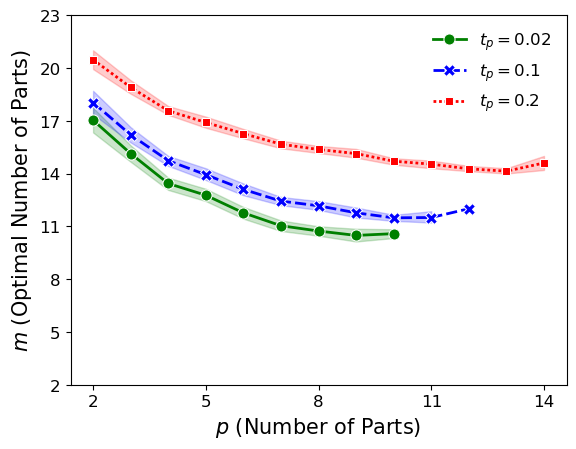

In [26]:
colors = ['green', 'blue', 'red']

plt.style.use("default")
sns.set_palette("husl")
g = sns.lineplot(
    data=result,
    x="p", y="m", hue="tp", style="tp",
    markers=True, linewidth=2, markersize=8, palette=colors
)


plt.xticks(np.arange(2, np.max(result['p'])+1.1, step=3), fontsize=12)
plt.yticks(np.arange(2, np.max(result['m'])+1.1, step=3), fontsize=12)
plt.xlabel("$p$ (Number of Parts)", fontsize=15)
plt.ylabel("$m$ (Optimal Number of Parts)", fontsize=15)
plt.legend(fontsize=12, frameon=False, labels=['$t_p = 0.02$', '$t_p=0.1$', '$t_p=0.2$'])
plt.savefig("multiple_tp.png", dpi=600)